# Starbucks Capstone Challenge

## Project Overview
In this project, I will use dataset from Starbucks which simulates how people make purchasing decisions and how those behaviors are influenced by promotional offers.

People have hidden traits which could influence their purchasing patterns and associated with their observable traits. These traits can be observed in their interactions with Starbucks app.

The data sets used in this analysis are in the form of the following three files:
* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed 

The schema and detailed explanation of each variable in the files will be explained along the analysis.


## Questions to Be Answer

In this analysis, I'm most interested in the following two questions: 
* Q1: Which offers are most effective?
* Q2: How can we split customers into different group? And how each group reacts to the offers?

For question one, I'll **compute the completion rates for each offer** to find the most effectice offer (That is , the offer with highest completion rate). And then, I would like to **run a simple decision tree model and visualize its spliting pattern** to get a sense of what factors might be important.


Next, for question two, I'll try to compute more features for the customer profile data, and run **clustering** on the data to see what kind of segmentation we get. And then we might be able to how each group respond to different offers (Again, completion rates or amount spent). 


## Data Exploration and Preprocessing
Explore and clean the three dataframe for data mining.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### 1. Portfolio Data
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [2]:
# Take a look
print("Portfolio: {} records".format(portfolio.shape[0]))
portfolio

Portfolio: 10 records


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


This dataset has only 10 records, corresponding to the 10 promotional offers.

In [3]:
# Data types
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


##### Assess
* Every entry's channels column has multiple values. The column could be splitted by different media.  
* Offer ids should be renamed for this analysis

##### Clean
* Split the channels column
* Rename the offer ids

In [4]:
# Copy
portfolio_clean = portfolio.copy()

# All media types
media = ['web', 'email', 'mobile', 'social']

# Create columns for all media
for medium in media:
    portfolio_clean['ch_' + medium] = portfolio_clean['channels'].str.contains(medium, regex=False)

# Change column order
new_col_order = [
    'id', 'offer_type', 'difficulty', 'duration', 'reward',
    'ch_web', 'ch_email', 'ch_mobile', 'ch_social'
]
portfolio_clean = portfolio_clean[new_col_order]

# Rename ids
old_to_new_ids = {
    'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo1',
    '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo2',
    '3f207df678b143eea3cee63160fa8bed': 'info1',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo3',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount1',
    '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount2',
    'fafdcd668e3743c1bb461111dcafc2a4': 'discount3',
    '5a8bc65990b245e5a138643cd4eb9837': 'info2',
    'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo4',
    '2906b810c7d4411798c6938adc9daaa5': 'discount4'
}
portfolio_clean['id'] = portfolio_clean['id'].map(old_to_new_ids) 

# Final result
portfolio_clean

,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social
0,bogo1,bogo,10,7,10,False,True,True,True
1,bogo2,bogo,10,5,10,True,True,True,True
2,info1,informational,0,4,0,True,True,True,False
3,bogo3,bogo,5,7,5,True,True,True,False
4,discount1,discount,20,10,5,True,True,False,False
5,discount2,discount,7,7,3,True,True,True,True
6,discount3,discount,10,10,2,True,True,True,True
7,info2,informational,0,3,0,False,True,True,True
8,bogo4,bogo,5,5,5,True,True,True,True
9,discount4,discount,10,7,2,True,True,True,False


#### 2. Profile Data
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [5]:
# Take a look
print("Profile: {} records".format(profile.shape[0]))
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

Profile: 17000 records


,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
# Data types
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null datetime64[ns]
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.1+ KB


In [7]:
# Missing values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [8]:
# What about age == 118
profile[profile['age']==118].sample(10)

,age,became_member_on,gender,id,income
11647,118,2017-03-24,None,f9d169fa4c254d99b334c09088772cd0,NaN
15846,118,2018-06-16,None,bcf0b562ebea4cb49013f521475e2fd5,NaN
7976,118,2017-11-24,None,73614a26789a49daa79dcc26664c1b72,NaN
13541,118,2013-08-02,None,e431ebcc6f944c5c9a2d93cbd4a790d7,NaN
12484,118,2016-07-27,None,b04385001db14fdf87829c6163ae9ddd,NaN
9010,118,2015-09-07,None,7440289df83149598c81f89fdcc9c51c,NaN
10248,118,2017-09-21,None,6fb2a442ccb44db9a4deb57f00a1fa7e,NaN
2886,118,2013-08-10,None,b685bf9de0794b44ba299464a95aa679,NaN
2429,118,2016-11-20,None,8e269f4308474449b814df285c4de66d,NaN
380,118,2016-06-18,None,a30a693afbd74047a3796bfb7d10e740,NaN


##### Assess
* About 2175 rows have missing data on gender and income, and their age are all 118.
* Person ids can be renamed

##### Clean
* Drop the 2175 abnormal rows
* Rename the person ids

In [9]:
# Copy the data
profile_clean = profile.copy()

# Rename Person Ids
# build a dict
person_id_map = {}
count = 1
for id_ in profile_clean.id.unique():
    person_id_map[id_] = 'person' + str(count)
    count = count+1
# rename
profile_clean['id'] = profile_clean['id'].map(person_id_map)

# Dropna
profile_clean = profile_clean.dropna()

# Resulting dataframe
profile_clean.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,person2,112000.0
3,75,2017-05-09,F,person4,100000.0
5,68,2018-04-26,M,person6,70000.0
8,65,2018-02-09,M,person9,53000.0
12,58,2017-11-11,M,person13,51000.0


##### Statistics and Visualization

In [10]:
# Statistics after dropping nan
profile_clean.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


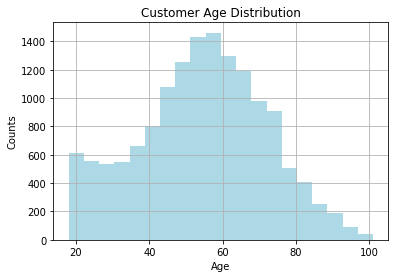

In [11]:
# Age distribution
profile_clean['age'].hist(bins=20, color='lightblue')
plt.title('Customer Age Distribution');
plt.ylabel('Counts');
plt.xlabel('Age');

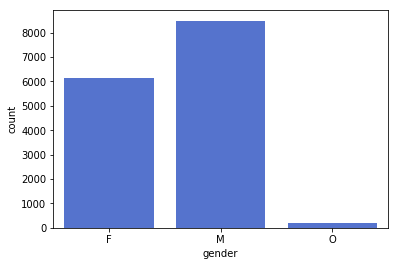

In [12]:
# Genders
sns.countplot(profile_clean['gender'].fillna('Unknown'), color='royalblue');

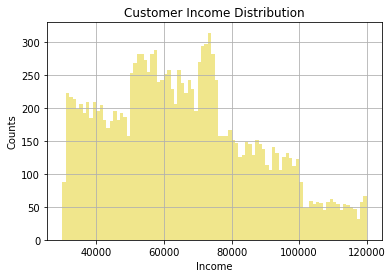

In [13]:
# Age distribution
profile_clean['income'].hist(bins=90, color='khaki')
plt.title('Customer Income Distribution');
plt.ylabel('Counts');
plt.xlabel('Income');

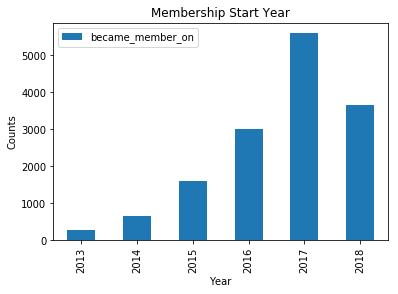

In [14]:
# https://stackoverflow.com/questions/27365467/can-pandas-plot-a-histogram-of-dates
# Membership start time
profile_clean[['became_member_on']].groupby([profile.became_member_on.dt.year]).count().plot.bar(width=0.5);
plt.title('Membership Start Year');
plt.ylabel('Counts');
plt.xlabel('Year');

#### 3. Transcript Data
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [15]:
# Take a look
print("Transcript: {} records".format(transcript.shape[0]))
transcript.head()

Transcript: 306534 records


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [16]:
# Data types
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [17]:
# Statistics
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [18]:
# event types
transcript.event.unique().tolist()

['offer received', 'offer viewed', 'transaction', 'offer completed']

In [19]:
# number of person recevied
print('Number of unique customer: {}'.format(transcript.person.nunique()))

Number of unique customer: 17000


In [20]:
# average offer received per person
print('Average offers received by a person: {}'.format(np.round(transcript.shape[0]/transcript.person.nunique(),0)))

Average offers received by a person: 18.0


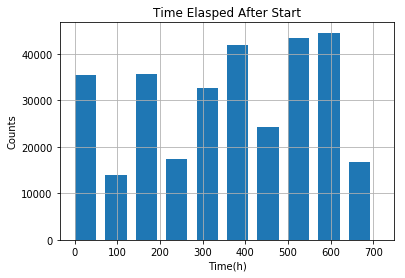

In [21]:
# Test time elapsed
transcript.time.hist(width=50);
plt.title('Time Elasped After Start');
plt.ylabel('Counts');
plt.xlabel('Time(h)');

In [22]:
# Event and actions
for event in transcript.event.unique().tolist():
    print('*** Event: {} ***'.format(event))
    print(transcript[transcript['event']==event][['event','value']].head(3))
    print()

*** Event: offer received ***
            event                                             value
0  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1  offer received  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2  offer received  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}

*** Event: offer viewed ***
              event                                             value
12650  offer viewed  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651  offer viewed  {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652  offer viewed  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}

*** Event: transaction ***
             event                           value
12654  transaction  {'amount': 0.8300000000000001}
12657  transaction               {'amount': 34.56}
12659  transaction               {'amount': 13.23}

*** Event: offer completed ***
                 event                                              value
12658  offer completed  {'offer_id': '2906b810c7d44

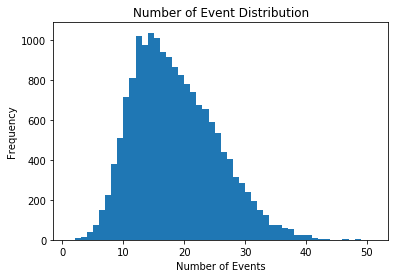

In [23]:
# Total event number for each person
transcript.groupby('person').size().plot.hist(bins=50)
plt.title('Number of Event Distribution');
plt.ylabel('Frequency');
plt.xlabel('Number of Events');

In [24]:
# Take a look on the events of single customer
transcript[transcript['person'] == transcript.person.sample().values[0]]

,event,person,time,value
482,offer received,c1e96618c1e74fd192f8a5bb29b014f3,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
39591,transaction,c1e96618c1e74fd192f8a5bb29b014f3,90,{'amount': 15.4}
39592,offer completed,c1e96618c1e74fd192f8a5bb29b014f3,90,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
47620,offer viewed,c1e96618c1e74fd192f8a5bb29b014f3,132,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
53652,offer received,c1e96618c1e74fd192f8a5bb29b014f3,168,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
72264,transaction,c1e96618c1e74fd192f8a5bb29b014f3,180,{'amount': 8.85}
101501,offer viewed,c1e96618c1e74fd192f8a5bb29b014f3,282,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
105954,transaction,c1e96618c1e74fd192f8a5bb29b014f3,306,{'amount': 13.56}
111317,offer received,c1e96618c1e74fd192f8a5bb29b014f3,336,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
141652,offer viewed,c1e96618c1e74fd192f8a5bb29b014f3,378,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}


In [25]:
transcript['person'].nunique()

17000

##### Assess
* In the value columns, offer id key has different forms: 'offer_id' and 'offer id'. This should be unified. 
* For the ease of processing, I'd like to split the dataframe into two: Offer related and transaction only
* `offer_id` values should be renamed based on previous section
* `person` id should be renamed based on previous section

##### Clean

* Split the `transcript` into `transaction_clean` and `offer_reaction_clean` 
* Rename `offer_id` values
* Rename `person` values

In [26]:
# Extract transaction only data
transaction_clean = transcript[transcript['event'] == 'transaction'].copy()
transaction_clean['amount'] = transaction_clean['value'].apply(lambda x: x['amount'])
transaction_clean = transaction_clean.drop(['event', 'value'], axis=1)

# Rename person
transaction_clean['person'] = transaction_clean['person'].map(person_id_map)

# Resulting dataframe
transaction_clean.head()

,person,time,amount
12654,person42,0,0.83
12657,person56,0,34.56
12659,person64,0,13.23
12670,person135,0,19.51
12671,person152,0,18.97


In [27]:
# Extract offer related data
offer_reaction_clean = transcript[transcript['event'] != 'transaction'].copy()
offer_reaction_clean['offer_id'] = offer_reaction_clean['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else x['offer id'])
offer_reaction_clean = offer_reaction_clean.drop(['value'], axis=1)

# Rename offer ids
offer_reaction_clean['offer_id'] = offer_reaction_clean['offer_id'].map(old_to_new_ids)

# Rename person
offer_reaction_clean['person'] = offer_reaction_clean['person'].map(person_id_map)

# Resulting dataframe
offer_reaction_clean.head()

,event,person,time,offer_id
0,offer received,person4,0,bogo3
1,offer received,person5,0,discount1
2,offer received,person6,0,discount4
3,offer received,person7,0,discount3
4,offer received,person8,0,bogo2


## Clean Data
Now that we have rather clean data, we can start the analysis.  
Here is a summary for the clean data:

#### portfolio_clean
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* ch_web (bool) - Web channel
* ch_email (bool) - Email channel
* ch_mobile (bool) - Mobile channel
* ch_social (bool) - Social channel

#### profile_clean
* age (int) - age of the customer 
* became_member_on (datetime64) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

#### transaction_clean
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* amount (float) - amount spent in the transaction

#### offer_reaction_clean
* event (str) - record description (offer received/offer viewed/offer completed)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* offer_id - (str) - offer id

In [28]:
portfolio_clean.head(3)

,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social
0,bogo1,bogo,10,7,10,False,True,True,True
1,bogo2,bogo,10,5,10,True,True,True,True
2,info1,informational,0,4,0,True,True,True,False


In [29]:
profile_clean.head(3)

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,person2,112000.0
3,75,2017-05-09,F,person4,100000.0
5,68,2018-04-26,M,person6,70000.0


In [30]:
transaction_clean.head(3)

,person,time,amount
12654,person42,0,0.83
12657,person56,0,34.56
12659,person64,0,13.23


In [31]:
offer_reaction_clean.head(3)

,event,person,time,offer_id
0,offer received,person4,0,bogo3
1,offer received,person5,0,discount1
2,offer received,person6,0,discount4


## Data Mining

In the following sections, I will perform further exploration or modeling on the clean dataset to answer the two questions listed in the early section.  
The exploration of the answers to each question will follow the CRISP-DM(Cross-Industry Standard Process for Data Mining) process.


### Q1: Which offers are most effective?
#### 1. Business Understaning
From an enterprise's point of view, evaluating and assessing marketing/promotion results is critical.  
These assessment can be made through simple summary of target metric of different features.  For more advanced analysis, statistical model such as decision tree might be helpful.

##### Target Metric
* Offer completion rate

##### Features
* Offer type
* Duration/difficulty/reward
* Channel
* Other computed features


#### 2. Data Understaning
I'll use only `portfolio_clean` and `offer_reaction_clean` in these section.  Let's explore the data further.

In [32]:
# Portfolio
portfolio_clean

,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social
0,bogo1,bogo,10,7,10,False,True,True,True
1,bogo2,bogo,10,5,10,True,True,True,True
2,info1,informational,0,4,0,True,True,True,False
3,bogo3,bogo,5,7,5,True,True,True,False
4,discount1,discount,20,10,5,True,True,False,False
5,discount2,discount,7,7,3,True,True,True,True
6,discount3,discount,10,10,2,True,True,True,True
7,info2,informational,0,3,0,False,True,True,True
8,bogo4,bogo,5,5,5,True,True,True,True
9,discount4,discount,10,7,2,True,True,True,False


In [33]:
# Offer Reaction
print("Offer Reaction: {} records".format(offer_reaction_clean.shape[0]))
offer_reaction_clean.sample(5)

Offer Reaction: 167581 records


,event,person,time,offer_id
217411,offer viewed,person12688,504,bogo1
211893,offer received,person13975,504,discount4
150668,offer received,person96,408,bogo2
124415,offer viewed,person3976,336,discount3
211524,offer received,person13078,504,bogo3


**Observation**  

`portfolio_clean` is lack of target metric (completion rate), which can be calculated using `offer_reaction_clean`.  
Besides target metric, some auxiliary features(view rates, etc) can also be computed from `offer_reaction_clean` data.

#### 3. Data Preparation


In [34]:
# Make a copy
df_Q1 = portfolio_clean.copy()

In [35]:
# Compute offer statistics
offer_statistics = []
for offer_id in offer_reaction_clean['offer_id'].unique():
    offer_stat = offer_reaction_clean[offer_reaction_clean['offer_id'] == offer_id].groupby('event').size().to_dict()
    offer_stat['id'] = offer_id
    offer_statistics.append(offer_stat)

# Transform the statistics into Dataframe
df_offer_stat = pd.DataFrame(offer_statistics)[['id', 'offer received', 'offer viewed', 'offer completed']]

# Compute the rate
df_offer_stat['offer_complete_rate'] = df_offer_stat['offer completed'] / df_offer_stat['offer received']
df_offer_stat['offer_view_rate'] = df_offer_stat['offer viewed'] / df_offer_stat['offer received']

# Keep the columns interested
#df_offer_stat = df_offer_stat[['id', 'offer_view_rate', 'offer_complete_rate']]
df_offer_stat

,id,offer received,offer viewed,offer completed,offer_complete_rate,offer_view_rate
0,bogo3,7677,4171,4354.0,0.567149,0.543311
1,discount1,7668,2663,3420.0,0.446009,0.347287
2,discount4,7632,4118,4017.0,0.526336,0.539570
3,discount3,7597,7327,5317.0,0.699882,0.964460
4,bogo2,7593,7298,3331.0,0.438694,0.961148
5,bogo4,7571,7264,4296.0,0.567428,0.959451
6,discount2,7646,7337,5156.0,0.674340,0.959587
7,info1,7617,4144,NaN,NaN,0.544046
8,bogo1,7658,6716,3688.0,0.481588,0.876991
9,info2,7618,6687,NaN,NaN,0.877789


In [36]:
# Join the dataset
df_Q1 = df_Q1.join(df_offer_stat.set_index('id'), on='id').drop(['offer received', 'offer viewed', 'offer completed'], axis=1)
df_Q1

,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social,offer_complete_rate,offer_view_rate
0,bogo1,bogo,10,7,10,False,True,True,True,0.481588,0.876991
1,bogo2,bogo,10,5,10,True,True,True,True,0.438694,0.961148
2,info1,informational,0,4,0,True,True,True,False,NaN,0.544046
3,bogo3,bogo,5,7,5,True,True,True,False,0.567149,0.543311
4,discount1,discount,20,10,5,True,True,False,False,0.446009,0.347287
5,discount2,discount,7,7,3,True,True,True,True,0.674340,0.959587
6,discount3,discount,10,10,2,True,True,True,True,0.699882,0.964460
7,info2,informational,0,3,0,False,True,True,True,NaN,0.877789
8,bogo4,bogo,5,5,5,True,True,True,True,0.567428,0.959451
9,discount4,discount,10,7,2,True,True,True,False,0.526336,0.539570


#### 4. Results evaluation
##### (1) Offer Complete Rate by Offer Type

In [37]:
# Since informational offer has not complete status, I'll drop those records
df_Q1_comp = df_Q1[['id', 'offer_type', 'offer_complete_rate']].sort_values(by='offer_complete_rate', ascending=False).dropna()
df_Q1_comp

,id,offer_type,offer_complete_rate
6,discount3,discount,0.699882
5,discount2,discount,0.674340
8,bogo4,bogo,0.567428
3,bogo3,bogo,0.567149
9,discount4,discount,0.526336
0,bogo1,bogo,0.481588
4,discount1,discount,0.446009
1,bogo2,bogo,0.438694


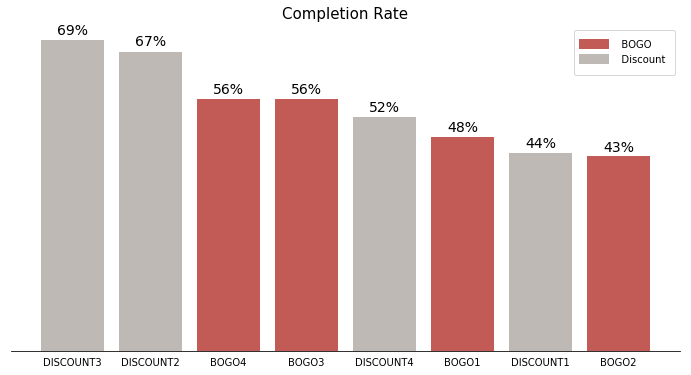

In [47]:
# Color map for bogo and discount
# https://www.colorcombos.com/
cate_colors = df_Q1_comp.offer_type.map({'bogo': '#c25b56', 'discount': '#beb9b5'})

# Percentage
df_Q1_comp['offer_complete_rate_per'] = df_Q1_comp['offer_complete_rate'].apply(lambda x: np.round(x*100, 2))

# Plottling
fig, ax = plt.subplots(figsize=(12,6))
bar_rect = ax.bar(x=df_Q1_comp['id'].str.upper(), height=df_Q1_comp['offer_complete_rate_per'], color=cate_colors)
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Legned for color ref: https://matplotlib.org/gallery/text_labels_and_annotations/custom_legends.html
custom_lines = [Line2D([0], [0], color='#c25b56', lw=10),
                Line2D([0], [0], color='#beb9b5', lw=10)]
ax.legend(custom_lines, ['   BOGO', '   Discount'], borderpad=1);

# Hide x ticks
plt.tick_params(axis='x', which='both', bottom=False)

# Autolabel Function
# https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
def autolabel(rects, unit=''):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height == 0: continue
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height) + unit,
                ha='center', va='bottom', fontsize=14)

# Label the percentage on top of bars
autolabel(bar_rect, '%')
plt.title('Completion Rate', size=15);

In [44]:
# Avergage completion rate by type
df_Q1_comp.groupby(['offer_type']).mean()[['offer_complete_rate']]

,offer_complete_rate
offer_type,
bogo,0.513715
discount,0.586642


##### Observation
* The two highest completion rates come from discount offers.
* Discount offer also has higher completion rate in average.

##### (2) Offer View Rate by Offer Type

In [39]:
# Data for view rate
df_Q1_view= df_Q1[['id', 'offer_type', 'offer_view_rate']].sort_values(by='offer_view_rate', ascending=False)
df_Q1_view

,id,offer_type,offer_view_rate
6,discount3,discount,0.964460
1,bogo2,bogo,0.961148
5,discount2,discount,0.959587
8,bogo4,bogo,0.959451
7,info2,informational,0.877789
0,bogo1,bogo,0.876991
2,info1,informational,0.544046
3,bogo3,bogo,0.543311
9,discount4,discount,0.539570
4,discount1,discount,0.347287


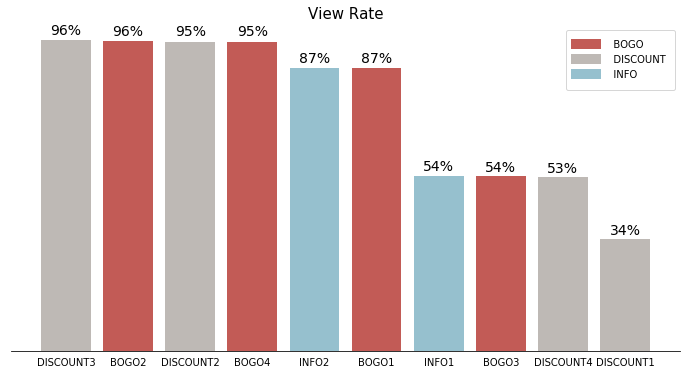

In [46]:
# Color map for bogo and discount
# https://www.colorcombos.com/
cate_colors = df_Q1_view.offer_type.map({'bogo': '#c25b56', 'discount': '#beb9b5', 'informational': '#96c0ce'})

# Percentage
df_Q1_view['offer_view_rate_per'] = df_Q1_view['offer_view_rate'].apply(lambda x: np.round(x*100, 2))

# Plottling
fig, ax = plt.subplots(figsize=(12,6))
bar_rect = ax.bar(x=df_Q1_view['id'].str.upper(), height=df_Q1_view['offer_view_rate_per'], color=cate_colors)
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Legned for color ref: https://matplotlib.org/gallery/text_labels_and_annotations/custom_legends.html
custom_lines = [Line2D([0], [0], color='#c25b56', lw=10),
                Line2D([0], [0], color='#beb9b5', lw=10),
                Line2D([0], [0], color='#96c0ce', lw=10)]
ax.legend(custom_lines, ['   BOGO', '   DISCOUNT', '   INFO'], borderpad=1);

# Hide x ticks
plt.tick_params(axis='x', which='both', bottom=False)

# Autolabel Function
# https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
def autolabel(rects, unit=''):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height == 0: continue
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height) + unit,
                ha='center', va='bottom', fontsize=14)

# Label the percentage on top of bars
autolabel(bar_rect, '%')
plt.title('View Rate', size=15);

In [45]:
# Avergage view rate by type
df_Q1_view.groupby(['offer_type']).mean()[['offer_view_rate']]

,offer_view_rate
offer_type,
bogo,0.835225
discount,0.702726
informational,0.710918


##### Observation
* BOGO offer has higher view rate in average.
* BOGO2 has very high view rate but low completion rate.

##### (3) Offer Complete Rate correlation with other numerical parameters

In [48]:
df_Q1

,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social,offer_complete_rate,offer_view_rate
0,bogo1,bogo,10,7,10,False,True,True,True,0.481588,0.876991
1,bogo2,bogo,10,5,10,True,True,True,True,0.438694,0.961148
2,info1,informational,0,4,0,True,True,True,False,NaN,0.544046
3,bogo3,bogo,5,7,5,True,True,True,False,0.567149,0.543311
4,discount1,discount,20,10,5,True,True,False,False,0.446009,0.347287
5,discount2,discount,7,7,3,True,True,True,True,0.674340,0.959587
6,discount3,discount,10,10,2,True,True,True,True,0.699882,0.964460
7,info2,informational,0,3,0,False,True,True,True,NaN,0.877789
8,bogo4,bogo,5,5,5,True,True,True,True,0.567428,0.959451
9,discount4,discount,10,7,2,True,True,True,False,0.526336,0.539570


In [49]:
# Correlation
q1_corr = df_Q1[['difficulty', 'duration', 'reward', 'offer_view_rate', 'offer_complete_rate']].corr()
q1_corr

,difficulty,duration,reward,offer_view_rate,offer_complete_rate
difficulty,1.000000,0.808414,0.465686,-0.300024,-0.487553
duration,0.808414,1.000000,0.160262,-0.255880,0.248762
reward,0.465686,0.160262,1.000000,0.224391,-0.697518
offer_view_rate,-0.300024,-0.255880,0.224391,1.000000,0.424601
offer_complete_rate,-0.487553,0.248762,-0.697518,0.424601,1.000000


In [50]:
# Corr Ploting
# https://stackoverflow.com/questions/39409866/correlation-heatmap
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

q1_corr.style.background_gradient(cmap, axis=1).set_properties(**{'max-width': '80px', 'font-size': '10pt'}).set_precision(2)

,difficulty,duration,reward,offer_view_rate,offer_complete_rate
difficulty,1,0.81,0.47,-0.3,-0.49
duration,0.81,1,0.16,-0.26,0.25
reward,0.47,0.16,1,0.22,-0.7
offer_view_rate,-0.3,-0.26,0.22,1,0.42
offer_complete_rate,-0.49,0.25,-0.7,0.42,1


##### Observation
* Offer complete rate has moderate positive correlation with offer view rate, and weak positive correlation with offer duration .
* Offer complete rate has moderate negative relationship with difficulty and reward.
* Note that there are some colinearities exist in the parameters(such as difficulty and reward).
* Note that the data might be not enough to conclude the relationship.

### Q2: How can we split customers into different group? And how each group reacts to the offers?

Next, for question two, I'll try to compute more features for the customer profile data, and run **clustering** on the data to see what kind of segmentation we get. And then we might be able to how each group respond to different offers (Again, completion rates or amount spent). 

#### 1. Business Understaning
#### 2. Data Understaning
#### 3. Data Preparation
#### 4. Data Modeling
#### 5. Results evaluation

#### 4. Data Modeling

In [39]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(max_depth=3)

# features
X = df_Q1.drop(['id', 'offer received', 'offer viewed', 'offer completed', 'offer_complete_rate'], axis=1)
X = X.join(pd.get_dummies(X['offer_type'])).drop(['offer_type'], axis=1) # one-hot encode offer=type

y = df_Q1[['offer_complete_rate']].fillna(0)
reg.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

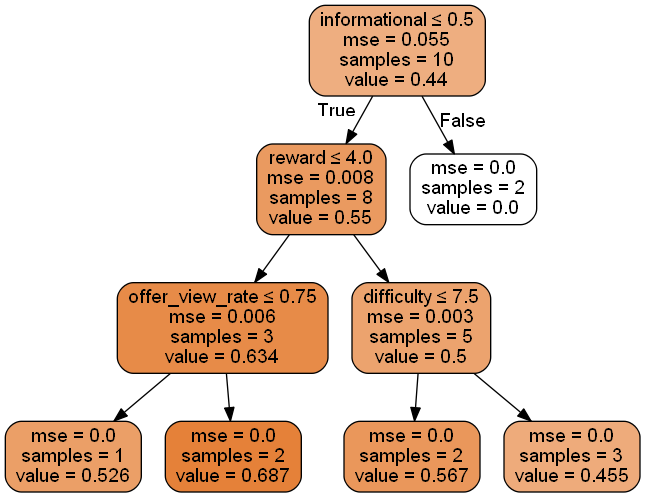

In [40]:
# https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(reg, out_file=dot_data,
                feature_names = X.columns,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [44]:
dict(zip(X.columns, reg.feature_importances_))

{'difficulty': 0.027304442010931112,
 'duration': 0.0,
 'reward': 0.06062825595901996,
 'ch_web': 0.0,
 'ch_email': 0.0,
 'ch_mobile': 0.0,
 'ch_social': 0.0,
 'offer_view_rate': 0.03133696411121731,
 'bogo': 0.0,
 'discount': 0.0,
 'informational': 0.8807303379188316}

In [44]:
print('Total # of People: {}'.format(offer_reaction_clean['person'].nunique()))
for offer_id in offer_reaction_clean['offer_id'].unique():
    print('offer id: {}, # of people {}'.format(offer_id, offer_reaction_clean[offer_reaction_clean['offer_id'] == offer_id].person.nunique()))

Total # of People: 16994
offer id: 9b98b8c7a33c4b65b9aebfe6a799e6d9, # of people 6355
offer id: 0b1e1539f2cc45b7b9fa7c272da2e1d7, # of people 6374
offer id: 2906b810c7d4411798c6938adc9daaa5, # of people 6285
offer id: fafdcd668e3743c1bb461111dcafc2a4, # of people 6332
offer id: 4d5c57ea9a6940dd891ad53e9dbe8da0, # of people 6330
offer id: f19421c1d4aa40978ebb69ca19b0e20d, # of people 6262
offer id: 2298d6c36e964ae4a3e7e9706d1fb8c2, # of people 6325
offer id: 3f207df678b143eea3cee63160fa8bed, # of people 6331
offer id: ae264e3637204a6fb9bb56bc8210ddfd, # of people 6374
offer id: 5a8bc65990b245e5a138643cd4eb9837, # of people 6320


### Compute Attributes for Offers
* Offer View Rate
* Offer Completion Rate
* Number of Offer Issued  


In [ ]:
# Compute offer statistics
offer_statistics = []
for offer_id in offer_reaction_clean['offer_id'].unique():
    offer_stat = offer_reaction_clean[offer_reaction_clean['offer_id'] == offer_id].groupby('event').size().to_dict()
    offer_stat['id'] = offer_id
    offer_statistics.append(offer_stat)

offer_statistics

In [34]:
df_offer_stat = pd.DataFrame(offer_statistics)[['id', 'offer received', 'offer viewed', 'offer completed']]
df_offer_stat

,id,offer received,offer viewed,offer completed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,4171,4354.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,2663,3420.0
2,2906b810c7d4411798c6938adc9daaa5,7632,4118,4017.0
3,fafdcd668e3743c1bb461111dcafc2a4,7597,7327,5317.0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,7298,3331.0
5,f19421c1d4aa40978ebb69ca19b0e20d,7571,7264,4296.0
6,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,7337,5156.0
7,3f207df678b143eea3cee63160fa8bed,7617,4144,NaN
8,ae264e3637204a6fb9bb56bc8210ddfd,7658,6716,3688.0
9,5a8bc65990b245e5a138643cd4eb9837,7618,6687,NaN


In [36]:
portfolio_clean = portfolio_clean.join(df_offer_stat.set_index('id'), on='id').fillna(0)
portfolio_clean['completed rate'] = portfolio_clean['offer completed'] / portfolio_clean['offer received']
portfolio_clean['view_over_received'] = portfolio_clean['offer viewed'] / portfolio_clean['offer received']

In [37]:
portfolio_clean

,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social,offer received,offer viewed,offer completed,completed rate,view_over_received
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,7,10,False,True,True,True,7658,6716,3688.0,0.481588,0.876991
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,5,10,True,True,True,True,7593,7298,3331.0,0.438694,0.961148
2,3f207df678b143eea3cee63160fa8bed,informational,0,4,0,True,True,True,False,7617,4144,0.0,0.000000,0.544046
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,5,True,True,True,False,7677,4171,4354.0,0.567149,0.543311
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,10,5,True,True,False,False,7668,2663,3420.0,0.446009,0.347287
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,7,3,True,True,True,True,7646,7337,5156.0,0.674340,0.959587
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,2,True,True,True,True,7597,7327,5317.0,0.699882,0.964460
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,3,0,False,True,True,True,7618,6687,0.0,0.000000,0.877789
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,True,True,True,True,7571,7264,4296.0,0.567428,0.959451
9,2906b810c7d4411798c6938adc9daaa5,discount,10,7,2,True,True,True,False,7632,4118,4017.0,0.526336,0.539570


### Compute Attributes for Person

In [36]:
# Compute person statistics
person_statistics = []
for person in offer_reaction_clean['person'].unique():
    person_stat = offer_reaction_clean[offer_reaction_clean['person'] == person].groupby('event').size().to_dict()
    person_stat['person'] = person
    person_statistics.append(person_stat)

person_statistics

KeyboardInterrupt: 

In [62]:
import pickle

with open('person_statistics.pickle', 'wb') as handle:
    pickle.dump(person_statistics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
import pickle
with open('person_statistics.pickle', 'rb') as handle:
    person_statistics = pickle.load(handle)

#person_statistics

In [40]:
df_person_stat = pd.DataFrame(person_statistics)[['person', 'offer received', 'offer viewed', 'offer completed']].fillna(0)
df_person_stat

,person,offer received,offer viewed,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,4,4.0,3.0
1,a03223e636434f42ac4c3df47e8bac43,5,3.0,0.0
2,e2127556f4f64592b11af22de27a7932,4,3.0,2.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,5,5.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,5,4.0,0.0
5,389bc3fa690240e798340f5a15918d5c,6,6.0,5.0
6,c4863c7985cf408faee930f111475da3,3,3.0,1.0
7,2eeac8d8feae4a8cad5a6af0499a211d,3,2.0,1.0
8,aa4862eba776480b8bb9c68455b8c2e1,5,5.0,3.0
9,31dda685af34476cad5bc968bdb01c53,6,5.0,4.0


In [41]:
profile_clean = profile_clean.join(df_person_stat.set_index('person'), on='id')
profile_clean = profile_clean.dropna()
profile_clean

,age,became_member_on,gender,id,income,offer received,offer viewed,offer completed
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2.0,0.0,1.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4.0,4.0,3.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,4.0,3.0,2.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,6.0,6.0,5.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,3.0,2.0,1.0
13,61,2017-09-11,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,5.0,5.0,3.0
14,26,2014-02-13,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,6.0,1.0,1.0
15,62,2016-02-11,F,31dda685af34476cad5bc968bdb01c53,71000.0,6.0,5.0,4.0
16,49,2014-11-13,M,62cf5e10845442329191fc246e7bcea3,52000.0,3.0,2.0,1.0
18,57,2017-12-31,M,6445de3b47274c759400cd68131d91b4,42000.0,5.0,1.0,2.0


## Methodology
### Data Preprocessing
All preprocessing steps have been clearly documented. Abnormalities or characteristics about the data or input that needed to be addressed have been corrected. If no data preprocessing is necessary, it has been clearly justified.
### Implementation
The process for which metrics, algorithms, and techniques were implemented with the given datasets or input data has been thoroughly documented. Complications that occurred during the coding process are discussed.
### Refinement
The process of improving upon the algorithms and techniques used is clearly documented. Both the initial and final solutions are reported, along with intermediate solutions, if necessary.

## Results
### Model Evaluation and Validation
If a model is used, the following should hold: The final model’s qualities — such as parameters — are evaluated in detail. Some type of analysis is used to validate the robustness of the model’s solution.

Alternatively a student may choose to answer questions with data visualizations or other means that don't involve machine learning if a different approach best helps them address their question(s) of interest.
### Justification
he final results are discussed in detail.
Exploration as to why some techniques worked better than others, or how improvements were made are documented.

## Conclusion
### Reflection
Student adequately summarizes the end-to-end problem solution and discusses one or two particular aspects of the project they found interesting or difficult.
### Improvement
Discussion is made as to how at least one aspect of the implementation could be improved. Potential solutions resulting from these improvements are considered and compared/contrasted to the current solution.

## Deliverables
### Write-up or Application
If the student chooses to provide a blog post the following must hold: Project report follows a well-organized structure and would be readily understood by a technical audience. Each section is written in a clear, concise and specific manner. Few grammatical and spelling mistakes are present. All resources used to complete the project are cited and referenced.

If the student chooses to submit a web-application, the following holds: There is a web application that utilizes data to inform how the web application works. The application does not need to be hosted, but directions for how to run the application on a local machine should be documented.
### GitHub Repository
Student must have a Github repository of their project. The repository must have a README.md file that communicates the libraries used, the motivation for the project, the files in the repository with a small description of each, a summary of the results of the analysis, and necessary acknowledgements. If the student submits a web app rather than a blog post, then the Project Definition, Analysis, and Conclusion should be included in the README file, or in their Jupyter Notebook. Students should not use another student's code to complete the project, but they may use other references on the web including StackOverflow and Kaggle to complete the project.
### Best Practices
Code is formatted neatly with comments and uses DRY principles. A README file is provided that provides. PEP8 is used as a guideline for best coding practices.

Best practices from software engineering and communication lessons are used to create a phenomenal end product that students can be proud to showcase!